In [0]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.stats as stats
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
import numpy as np
import skimage as sm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io
import pandas as pd
import extcolors
import random


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Feature Extraction

In [0]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()
 
# Change thresholds
params.minThreshold = 0;
params.maxThreshold = 254;
 
# Filter by Area.
params.filterByArea = False

# Filter by Circularity
params.filterByCircularity = False

 
# Filter by Convexity
params.filterByConvexity = False

# Filter by Inertia
params.filterByInertia = False

In [0]:
new_entry = {'file name': [],'fruit type':[], 'rgbmean': [], 'convexity':[], 'circularity':[], 'inertia ratio':[]}
features = pd.DataFrame(new_entry)
path = "/content/drive/My Drive/186/fruits/"
fruit_folders = ["apples/", "oranges/", "bananas/"]
ind = 0
labels = ['red','orange','yellow']

for folder in fruit_folders:
    wdir = path + folder
    files = wdir+"*.jpg"
    ftype = labels[ind]
    ind +=1
    print(folder)
    for file in glob.glob(files):
        filename = file[-6:-4]
        fruit = cv2.imread(filename=file)
        
        gray = cv2.cvtColor(fruit, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
        cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv2.contourArea)[-1]
        x,y,w,h = cv2.boundingRect(cnt)
        dst = fruit[y:y+h, x:x+w]
        save_file = wdir+"cropped/"+filename+"-cropped.jpg"
        cv2.imwrite(save_file,dst)
        
        fruit_c = cv2.imread(filename=save_file)
        fruit_rgb_mean = np.mean(fruit_c/256)
        
        ret,thresh = cv2.threshold(gray,240,255,cv2.THRESH_BINARY_INV)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
      # Set up the detector with default parameters.
        detector = cv2.SimpleBlobDetector_create(params)
      # Detect blobs.
        keypoints = detector.detect(thresh)
        label, N = sm.measure.label(thresh, background=0, return_num=True)
        
        if N!=1:
            while N != 1:
                thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
                detector = cv2.SimpleBlobDetector_create(params)
                keypoints = detector.detect(thresh)
                label, N = sm.measure.label(thresh, background=0, return_num=True)
            #print(filename,N)
            binary = wdir+"cropped/"+filename+"-binary.jpg"
            cv2.imwrite(binary,thresh)
            reg = sm.measure.regionprops(label,thresh)
            area = reg[0].area
            conv_area = reg[0].convex_area
            perimeter = reg[0].perimeter
            inertia_a = reg[0].inertia_tensor_eigvals[0]
            inertia_b = reg[0].inertia_tensor_eigvals[1]
    
            convexity = area / conv_area
            circularity = (4* np.pi * area) / (perimeter**2)
            inertia = inertia_b/inertia_a
            #print(filename,' RGB MEAN:',fruit_rgb_mean,'; N:',N,'; Convexity:', convexity,'; Circularity:',circularity,'; Inertia:',inertia)
            new_entry = {'file name': filename,'fruit type':ftype,'rgbmean':fruit_rgb_mean, 'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
            features = features.append(new_entry, ignore_index=True)
        
            continue
        
        #print(N)
        binary = wdir+"cropped/"+filename+"-binary.jpg"
        cv2.imwrite(binary,thresh)
    
        reg = sm.measure.regionprops(label,thresh)
        area = reg[0].area
        conv_area = reg[0].convex_area
        perimeter = reg[0].perimeter
        inertia_a = reg[0].inertia_tensor_eigvals[0]
        inertia_b = reg[0].inertia_tensor_eigvals[1]
    
        convexity = area / conv_area
        circularity = (4* np.pi * area) / (perimeter**2)
        inertia = inertia_b/inertia_a        
        new_entry = {'file name': filename,'fruit type':ftype, 'rgbmean': fruit_rgb_mean,'convexity':convexity, 'circularity':circularity, 'inertia ratio':inertia}
        features = features.append(new_entry, ignore_index=True)

apples/


/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.6/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


oranges/
bananas/


#Features

In [0]:
features

,file name,fruit type,rgbmean,convexity,circularity,inertia ratio
0,02,red,0.595774,0.999024,0.892545,0.885877
1,37,red,0.587019,0.970451,0.807966,0.899403
2,19,red,0.500390,0.967210,0.775939,0.746720
3,08,red,0.497882,0.991004,0.878732,0.827307
4,03,red,0.529208,0.965941,0.633915,0.726095
5,25,red,0.566883,0.976699,0.824910,0.808698
6,26,red,0.498262,0.977636,0.821655,0.964853
7,09,red,0.489888,0.962301,0.749591,0.826559
8,34,red,0.564600,0.975133,0.818959,0.860007
9,38,red,0.581233,0.936779,0.611577,0.889765


In [0]:
apple = features[features['fruit type'] == 'red']
banana = features[features['fruit type'] == 'yellow']
orange = features[features['fruit type'] == 'orange']

# Removal Parts

In [0]:
feat = {'rgbmean': [], 'convexity':[], 'circularity':[], 'inertia ratio':[]}
app_features = pd.DataFrame(feat)
ban_features = pd.DataFrame(feat)
ora_features = pd.DataFrame(feat)

In [0]:
a1 = apple['rgbmean'] 
a3 = apple['circularity']
for i in a1.index:
    app_features = app_features.append({'rgbmean':a1[i], 'circularity':a2[i]}, ignore_index=True)
app_features

,rgbmean,circularity
0,0.595774,0.892545
1,0.587019,0.807966
2,0.500390,0.775939
3,0.497882,0.878732
4,0.529208,0.633915
5,0.566883,0.824910
6,0.498262,0.821655
7,0.489888,0.749591
8,0.564600,0.818959
9,0.581233,0.611577


In [0]:
b1 = banana['rgbmean']
b2 = banana['circularity']
for i in b1.index:
    ban_features = ban_features.append({'rgbmean':b1[i], 'circularity':b2[i]}, ignore_index=True)
ban_features

,rgbmean,circularity
0,0.777866,0.570066
1,0.778583,0.248079
2,0.808684,0.393451
3,0.771433,0.515053
4,0.771858,0.499743
5,0.744919,0.459161
6,0.830763,0.372539
7,0.816027,0.367893
8,0.815221,0.541977
9,0.766590,0.583468


In [0]:
o1 = orange['rgbmean']
o2 = orange['circularity']
for i in o1.index:
    ora_features = ora_features.append({'rgbmean':o1[i], 'circularity':o2[i]}, ignore_index=True)
ora_features

,rgbmean,circularity
0,0.690024,0.912255
1,0.672425,0.882327
2,0.693446,0.908354
3,0.726859,0.902494
4,0.675878,0.925542
5,0.700426,0.890208
6,0.671134,0.885469
7,0.704399,0.903646
8,0.670023,0.919638
9,0.631842,0.852036


#Feature Spaces

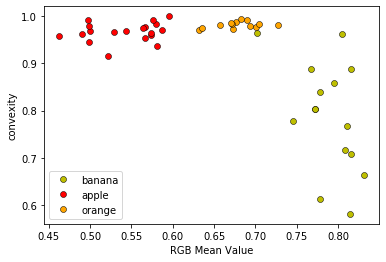

In [0]:
plt.plot(banana['rgbmean'], banana['convexity'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['convexity'], 'ro', mec='k', mew=0.5)
plt.plot(orange['rgbmean'], orange['convexity'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('convexity')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

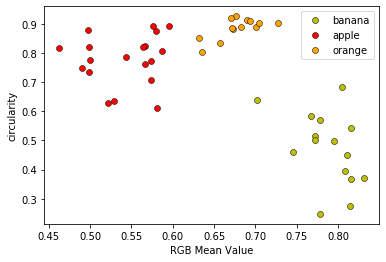

In [0]:
plt.plot(banana['rgbmean'], banana['circularity'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['circularity'], 'ro', mec='k', mew=0.5)
plt.plot(orange['rgbmean'], orange['circularity'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('circularity')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

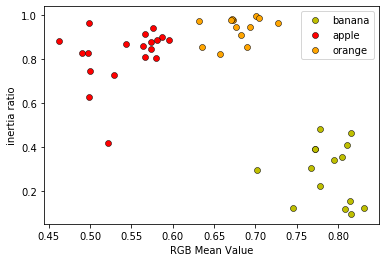

In [0]:
plt.plot(banana['rgbmean'], banana['inertia ratio'], 'yo', mec='k', mew=0.5)
plt.plot(apple['rgbmean'], apple['inertia ratio'], 'ro', mec='k', mew=0.5)
plt.plot(orange['rgbmean'], orange['inertia ratio'], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('RGB Mean Value')
plt.ylabel('inertia ratio')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

#Kendi Method

In [0]:
class ExpectationMaximization:
    def __init__(self, n_classes,
                 dimensions,
                 baseline=0.1):
        self.n_classes = n_classes
        self.dimensions = dimensions
        self.baseline = baseline
    
    def _p(self, x, mu, sigma):
        return 1/(2*np.pi)**(self.dimensions/2)/la.det(sigma)**(1/2) \
             * np.exp(-1/2 * (x - mu).T.dot(la.inv(sigma)).dot(x - mu))
    
    def _P(self, l, x):
        num = self.P[l] * self._p(x, self.theta['mu'][l], self.theta['cov'][l])
        den = 0.
        for m in range(self.n_classes):
            den += self.P[m] * self._p(x, self.theta['mu'][m], self.theta['cov'][l])
        return num/den
    
    def train(self, X, cluster_means, epochs=int(1e3)):
        self.graph_loss = []
        self.epochs = epochs
        N = len(X)
        ll_old = 0.
        self.theta = dict({'mu': cluster_means,
                           'cov': np.array([np.identity(self.dimensions) \
                                            for _ in range(self.n_classes)])
                          })
        self.P = np.ones(self.n_classes) * 1/self.n_classes
        for count in tnrange(epochs, desc='Epoch'):
            exp_A = []
            exp_B = []
            ll_new = 0.
            ws = np.zeros((self.n_classes, N))
            
            for l in range(self.n_classes):
                for i, x in enumerate(X):
                    ws[l,i] = self.P[l] * \
                              stats.multivariate_normal(self.theta['mu'][l],
                                                        self.theta['cov'][l],
                                                       ).pdf(x)
            ws /= ws.sum(0)
            
            Pnew = np.zeros(self.n_classes)
            for l in range(self.n_classes):
                for i in range(N):
                    Pnew[l] += ws[l,i]
            Pnew /= N
            
            mu_new = np.zeros((self.n_classes, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    mu_new[l] += ws[l,i] * X[i]
                mu_new[l] /= ws[l].sum()
            
            cov_new = np.zeros((self.n_classes, self.dimensions, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    ys = np.reshape(X[i] - mu_new[l], (2, 1))
                    cov_new[l] += ws[l,i] * ys.dot(ys.T)
                cov_new[l] /= ws[l].sum()
            
            ll_new = 0.
            for i in range(N):
                s = 0.
                for l in range(self.n_classes):
                    s += Pnew[l] * stats.multivariate_normal(self.theta['mu'][l],
                                                             self.theta['cov'][l]
                                                            ).pdf(X[i])
                ll_new += np.log(s)
            self.graph_loss.append(ll_new)
            if abs(ll_new - ll_old) < self.baseline:
                break
            ll_old = ll_new
            
            self.P = Pnew
            self.theta['mu'] = mu_new
            self.theta['cov'] = cov_new

In [0]:
astars = np.concatenate((app_features['rgbmean'], ban_features['rgbmean'], ora_features['rgbmean']))
bstars = np.concatenate((app_features['circularity'], ban_features['circularity'], ora_features['circularity']))
X = np.column_stack((astars, bstars))
cluster_means = np.array([[np.mean(app_features['rgbmean']), np.mean(app_features['circularity'])],
                          [np.mean(ban_features['rgbmean']), np.mean(ban_features['circularity'])],
                          [np.mean(ora_features['rgbmean']), np.mean(ora_features['circularity'])]
                         ])
em = ExpectationMaximization(3, 2, baseline=1e-4)
em.train(X, cluster_means)

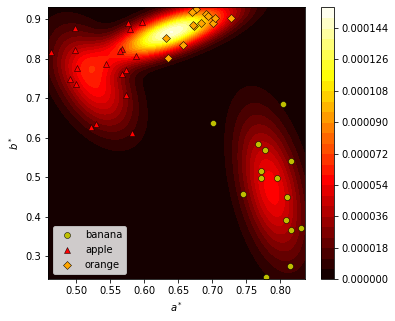

In [0]:
xs = np.linspace(astars.min()-5e-3, astars.max()+5e-3, 500)
ys = np.linspace(bstars.min()-5e-3, bstars.max()+5e-3, 500)
X, Y = np.meshgrid(xs, ys)
zs = np.vstack([X.ravel(), Y.ravel()]).T
Z = np.zeros(len(zs))
for p, m, s in zip(em.P, em.theta['mu'], em.theta['cov']):
    Z += p*stats.multivariate_normal(m, s).pdf(zs)
Z = Z.reshape(X.shape)
Z /= Z.size

plt.figure(figsize=(5*1.15, 5))
plt.plot(ban_features['rgbmean'], ban_features['circularity'], 'yo', mec='k', mew=0.5)
plt.plot(app_features['rgbmean'], app_features['circularity'], 'r^', mec='k', mew=0.5)
plt.plot(ora_features['rgbmean'], ora_features['circularity'], 'D', color = 'orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.contourf(X, Y, Z, cmap='hot', levels=25)
plt.colorbar()

# plt.savefig('em_feature_space.png', dpi=300, bbox_inches='tight')
plt.show()

#My Method - Expectation Maximization

In [0]:
#DEFAULT CONSTANTS
num_classes = 3
num_dimensions = 2
baseline = 1e-6

In [0]:
def p(x, mu, sigma):
  return 1/(2*np.pi)**(num_dimensions/2)/la.det(sigma)**(1/2) \
             * np.exp(-1/2 * (x - mu).T.dot(la.inv(sigma)).dot(x - mu))

def P(l, x):
        num = P[l] * p(x, theta['mu'][l], theta['cov'][l])
        den = 0.
        for m in range(num_classes):
            den += P[m] * p(x, theta['mu'][m], theta['cov'][l])
        return num/den

In [0]:
 def train(X, cluster_means, epochs=int(1e3)):
        graph_loss = []
        epochs = epochs
        N = len(X)
        ll_old = 0.
        theta = dict({'mu': cluster_means,
                           'cov': np.array([np.identity(num_dimensions) \
                                            for _ in range(num_classes)])
                          })
        P = np.ones(num_classes) * 1/num_classes
        for count in tnrange(epochs, desc='Epoch'):
            exp_A = []
            exp_B = []
            ll_new = 0.
            ws = np.zeros((num_classes, N))
            
            for l in range(num_classes):
                for i, x in enumerate(X):
                    ws[l,i] = P[l] * \
                              stats.multivariate_normal(theta['mu'][l],
                                                        theta['cov'][l],
                                                       ).pdf(x)
            ws /= ws.sum(0)
            
            Pnew = np.zeros(num_classes)
            for l in range(num_classes):
                for i in range(N):
                    Pnew[l] += ws[l,i]
            Pnew /= N
            
            mu_new = np.zeros((num_classes, num_dimensions))
            for l in range(num_classes):
                for i in range(N):
                    mu_new[l] += ws[l,i] * X[i]
                mu_new[l] /= ws[l].sum()
            
            cov_new = np.zeros((num_classes, num_dimensions, num_dimensions))
            for l in range(num_classes):
                for i in range(N):
                    ys = np.reshape(X[i] - mu_new[l], (2, 1))
                    cov_new[l] += ws[l,i] * ys.dot(ys.T)
                cov_new[l] /= ws[l].sum()
            
            ll_new = 0.
            for i in range(N):
                s = 0.
                for l in range(num_classes):
                    s += Pnew[l] * stats.multivariate_normal(theta['mu'][l],
                                                             theta['cov'][l]
                                                            ).pdf(X[i])
                ll_new += np.log(s)
            graph_loss.append(ll_new)
            if abs(ll_new - ll_old) < baseline:
                break
            ll_old = ll_new
            
            P = Pnew
            theta['mu'] = mu_new
            theta['cov'] = cov_new

            Z = np.zeros(len(zs))
            #print(np.shape(Z))
            for p, m, s in zip(P, theta['mu'], theta['cov']):
              Z += p*stats.multivariate_normal(m, s).pdf(zs)
            Z = Z.reshape(Xm.shape)
            #print(np.shape(Z))
            Z /= Z.size #Normalization step

            plt.figure(figsize=(5*1.15, 5))
            plt.plot(banana['rgbmean'], banana['inertia ratio'], 'yo', mec='k', mew=0.5)
            plt.plot(apple['rgbmean'], apple['inertia ratio'], 'r^', mec='k', mew=0.5)
            plt.plot(orange['rgbmean'], orange['inertia ratio'], 'D', color = 'orange', mec='k', mew=0.5)
            plt.legend(['banana', 'apple', 'orange'])
            plt.xlabel('RGB Mean Value')
            plt.ylabel('Inertia ratio')
            plt.contourf(Xm, Ym, Z, cmap='hot', levels=10)
            plt.colorbar()
            if count < 10:
              plt.savefig("/content/drive/My Drive/186/outputs/rgb-ratio/em_feature_space_0" +str(count)+".png", dpi=300, bbox_inches='tight')
            elif count >= 10:
              plt.savefig("/content/drive/My Drive/186/outputs/rgb-ratio/em_feature_space_" +str(count)+".png", dpi=300, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


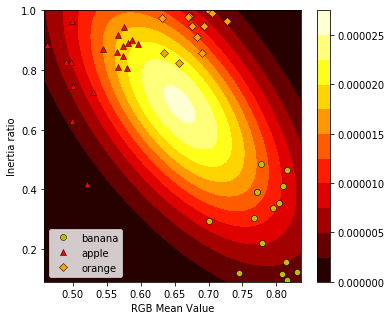

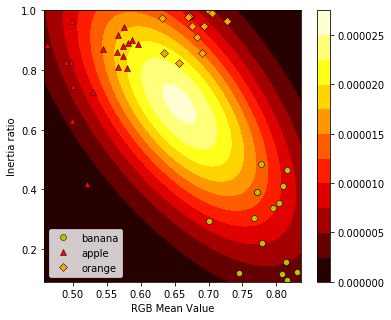

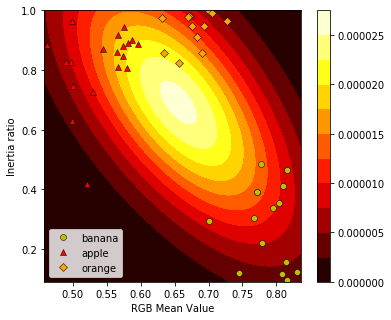

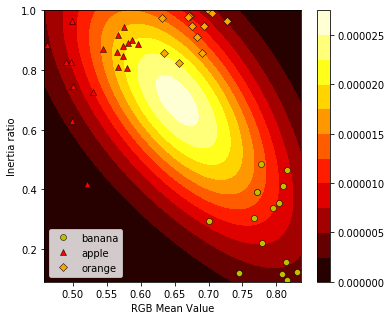

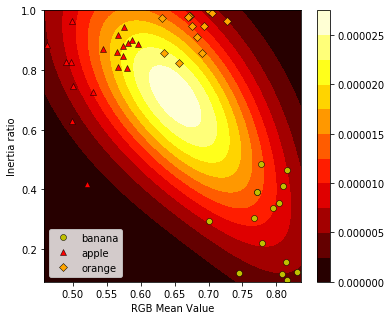

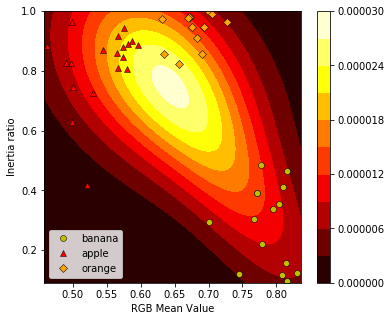

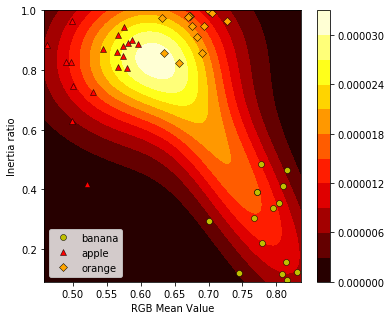

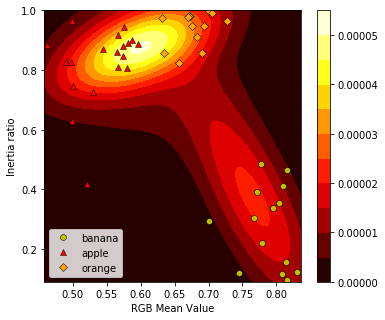

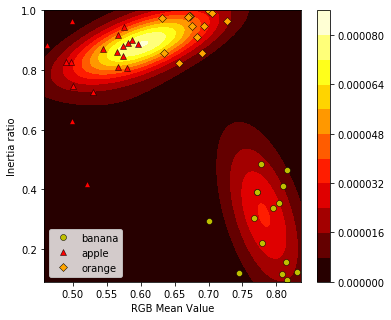

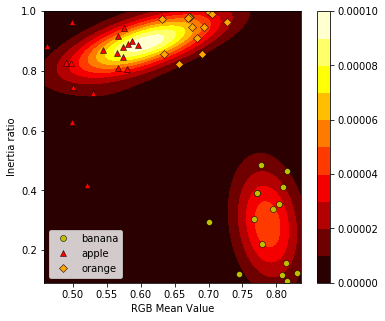

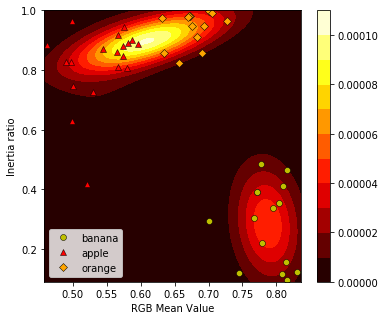

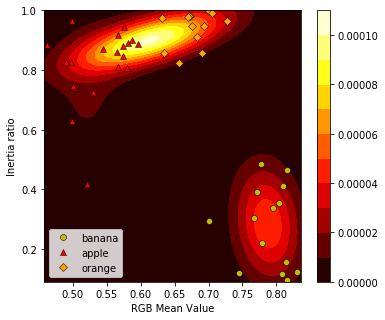

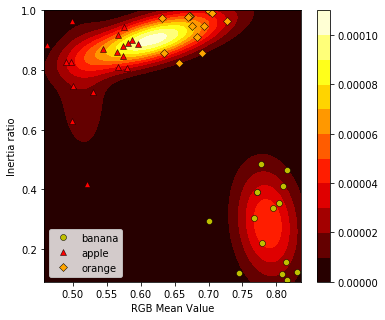

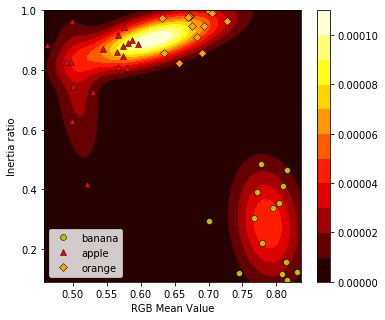

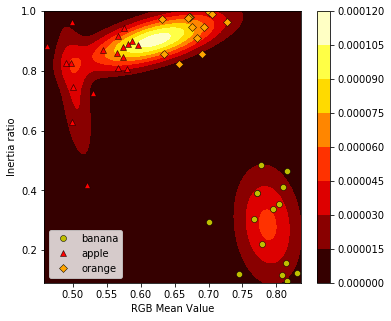

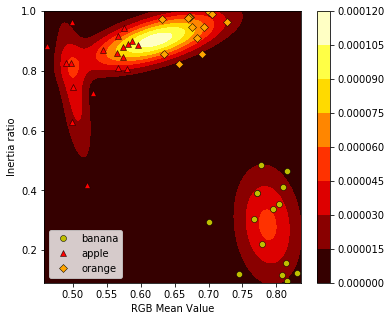

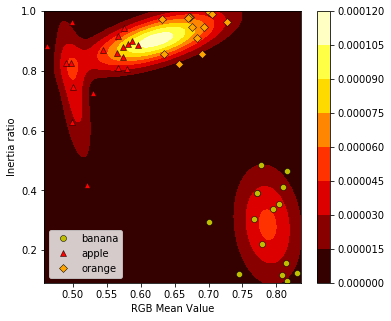

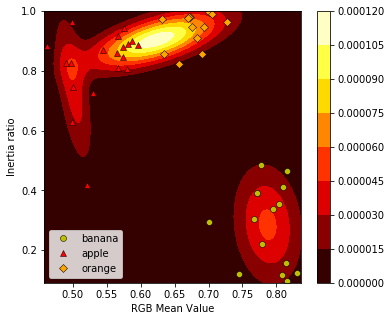

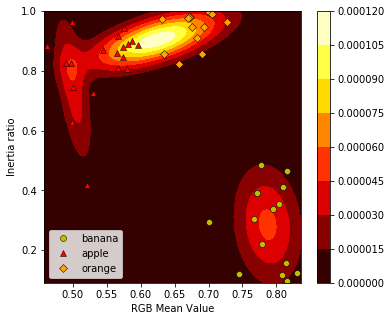

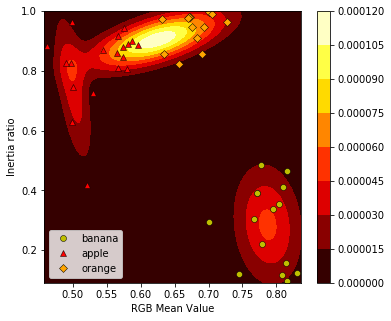

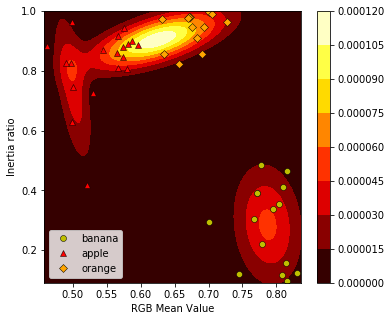

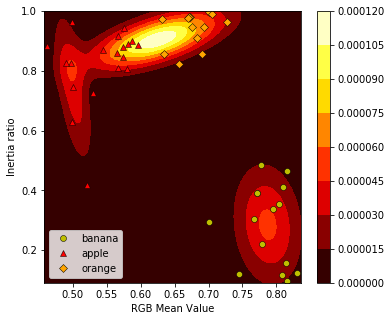

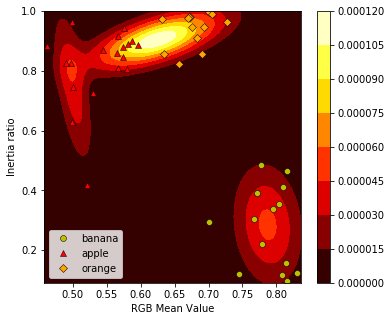

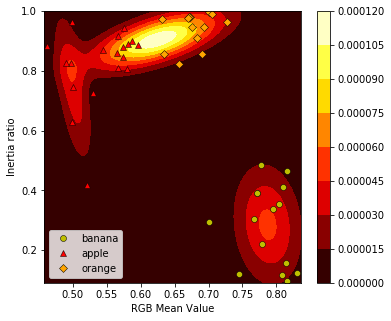

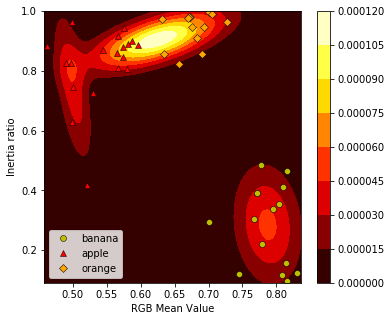

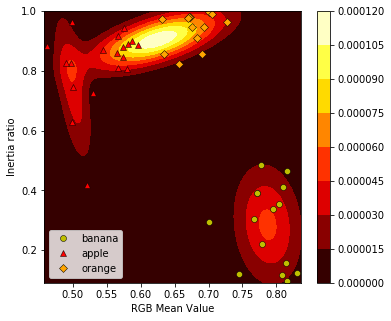

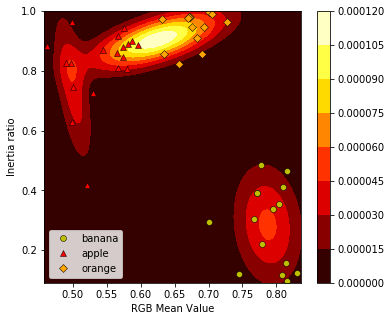

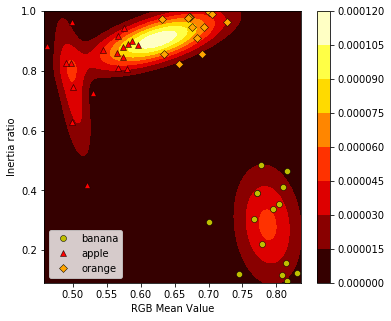

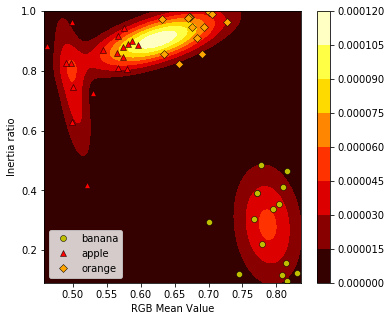

In [0]:
astars = np.concatenate((apple['rgbmean'], banana['rgbmean'], orange['rgbmean']))
bstars = np.concatenate((apple['inertia ratio'], banana['inertia ratio'], orange['inertia ratio']))
X = np.column_stack((astars, bstars))
cluster_means = np.array([[np.mean(apple['rgbmean']), np.mean(apple['inertia ratio'])],
                          [np.mean(banana['rgbmean']), np.mean(banana['inertia ratio'])],
                          [np.mean(orange['rgbmean']), np.mean(orange['inertia ratio'])]
                         ])

xs = np.linspace(astars.min()-5e-3, astars.max()+5e-3, 500)
ys = np.linspace(bstars.min()-5e-3, bstars.max()+5e-3, 500)
Xm, Ym = np.meshgrid(xs, ys)
zs = np.vstack([Xm.ravel(), Ym.ravel()]).T



train(X, cluster_means)